# Todos:
- add algo with conservation score: see https://moodle.polytechnique.fr/mod/resource/view.php?id=388407 page 21, ask teacher for more details
- add benchmark to compare methods

# Evaluation:
- 30 min presentation in total for both projects
- submit code: Jupyter notebook (with explaination and run example/launch instructions)

# Presentation:
- intro, intérêt, approche existante

### Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import RNA
import Bio

import tempfile
from IPython.display import SVG, HTML, display

# Type hinting
from typing import List, Set, Union

### Utility functions

In [2]:
def standardize_sequence(x:str) -> str:
    ''' Setting all caracters to upper case and converting T to U '''
    string = x.upper()
    string = string.replace('T', 'U')
    return string

def pairs2db(seq_lenth:int, pairs:Set[tuple]) -> str:
    ''' Parse set of pairs to dot bracket string '''
    dbstring = ['.'] * seq_lenth
    for pair in pairs:
        a, b = pair
        if a > b:
            a, b = b, a
        dbstring[a] = '('
        dbstring[b] = ')'
    return ''.join(dbstring)

def db2pairs(dbstring:str) -> Set[tuple]:
    ''' Parse dot bracket string to pairs '''
    pairs = set()
    stack = []
    for i in range(len(dbstring)):
        if dbstring[i] == '(':
            stack.append(i)
        elif dbstring[i] == ')':
            if len(stack) == 0:
                raise ValueError("Unbalanced brackets")
            else: 
                pairs.add((stack.pop(),i))    
    if len(stack) != 0:
        raise ValueError("Unbalanced brackets")
    return pairs

def is_canonical_basepair(x:str, y:str) -> bool:
    ''' Check if a pair is canonical '''
    _complementary_bases = set(["AU","CG","GC","GU","UA","UG"])
    return x+y in _complementary_bases

def is_canonical(seq:str, dbstring:str) -> bool:
    ''' Check if all the pairs of a structure are canonical '''
    pairs = db2pairs(dbstring)
    for pair in pairs:
        if not is_canonical_basepair(seq[pair[0]-1], seq[pair[1]-1]):
            return False
    return True

In [3]:
from Bio import AlignIO

def read_file(filename, filetype=None, verbose=False):
    if filetype is None: #we try to infer the type from the file extension
        if filename.split('.')[-1] == 'aln':
            filetype = 'clustal'
        elif filename.split('.')[-1] == 'stk':  
            filetype = 'stockholm'
        else:
            raise ValueError("File type not recognized")
    align = AlignIO.read(filename, filetype)
    if verbose: #A boolean flag indicating whether to print information about the alignment after reading.
        print(f"filetype: {filetype}")
        print(align)
    return align

In [4]:
# test
alignment = read_file('data/Testdata/tRNA_7.stk', verbose=True)

print(alignment[0].seq)
print()

alignment_list = [str(record.seq) for record in alignment]
print(alignment_list)

filetype: stockholm
Alignment with 7 rows and 85 columns
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCA...GCG AC021639.5_181586-181505
GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCC...GCA AP000063.1_59179-59095
UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACC...CAG AP000397.1_114390-114319
CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCG...CGA X03715.1_388-461
GCCGGGGUGGGGUAGUGGCCAUCCUGG---GGGACUGUGGAUCC...GCC U67517.1_7511-7582
GUAAACAUAGUUUA------AUCAAAACAUUAGAUUGUGAAUCU...ACC X99256.1_11558-11626
AGUAAAGUCAGCUA------AAAAAGCUUUUGGGCCCAUACCCC...CUA M10217.1_5910-5978
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG

['GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUU

### RnaMolecule class
A class for molecules that contains the sequence and the according structrure

In [5]:
class RnaMolecule:
    ''' Class to represent RNA molecule with sequence and structure

    Properties
    ----------
    sequence: str
        sequence of the molecule
    dbstring: str
        dot bracket string of the structure
    pairs: set
        set of pairs of the structure
    bpp: tupple of tuple
        base pair probability matrix. !!! the indices start at 1 (first line and column are 0)
    '''
    def __init__(self, sequence:str, structure=None):
        """
        Initialises an instance

        Args:
            sequence: str, sequence of the molecule
            structure: dbstring or set of pairs of the structure, optionnal
        """
        self.sequence = standardize_sequence(sequence)
        if structure is None:
            self.dbstring = '.' * len(sequence)
            self.pairs = set()
        elif type(structure) == str:
            self.dbstring = structure
            self.pairs = db2pairs(structure)
        elif type(structure) == set:   
            self.pairs = structure
            self.dbstring = pairs2db(len(sequence), structure)
        self.bpp = None

    def set_structure(self, structure=None):
        ''' Set the structure of the molecule
        If no structure is given, the minimum free energy (MFE) structure is computed with ViennaRNA'''
        if structure is None:
            model = RNA.md()
            model.uniq_ML = 1  # activate unique multibranch loop decomposition    
            fold_compound = RNA.fold_compound(self.sequence, model)
            structure, energy = fold_compound.mfe()
            fold_compound.exp_params_rescale(energy)
            fold_compound.pf()    # compute partition function to fill DP matrices

            self.bpp = fold_compound.bpp()

        if type(structure) == str:
            self.dbstring = structure
            self.pairs = db2pairs(structure)
        elif type(structure) == set:   
            self.pairs = structure
            self.dbstring = pairs2db(len(self.sequence), structure)
            
    
    def __str__(self):
        return f"RnaMolecule({self.sequence}, {self.dbstring})"

    def plot(self):
        ''' Plot the structure of the RNA molecule '''
        fp = tempfile.NamedTemporaryFile(suffix="svg")
        RNA.svg_rna_plot(self.sequence, structure=self.dbstring, ssfile=fp.name)
        display(SVG(fp.name))
    
    def plot_bpp(self):
        if self.bpp is None:
            print("bpp has not been computed")
            return
        bpp2 = [[math.sqrt(p)  for p in row[1:]]for row in self.bpp[1:]] # why use sqrt: only for better visualization of small values ?
        plt.imshow(bpp2)
        plt.title("base pair probability")
        plt.show()
        unp = [1-sum(self.bpp[i][j] + self.bpp[j][i] for j in range(1,len(self.bpp))) for i in range(1,len(self.bpp))]
        plt.plot(unp)
        plt.title("probability to be unpaired")
        plt.show()

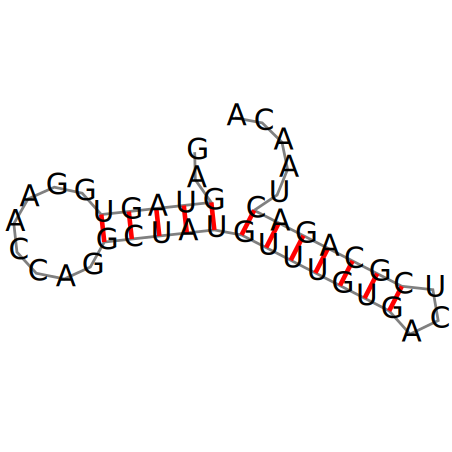

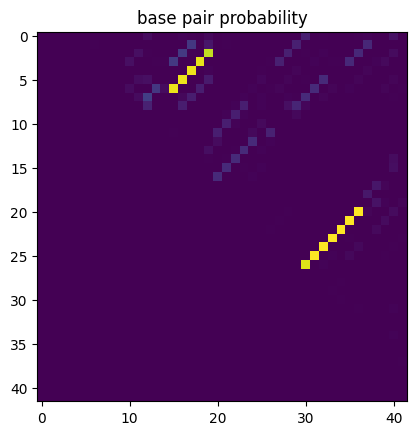

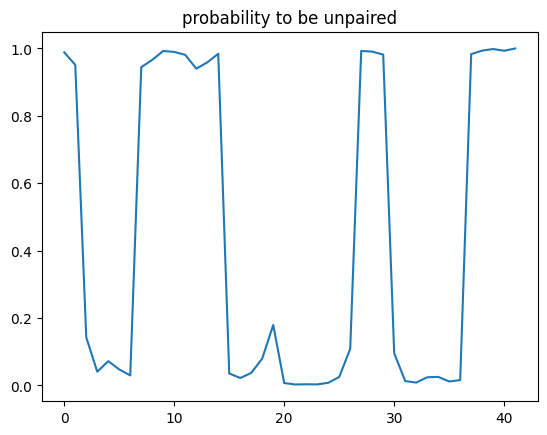

In [6]:
# test
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"

mol = RnaMolecule(sequence)
mol.set_structure()
mol.plot()
mol.plot_bpp()

# Computing the structure of an alignment

### Using the ViennaRNA package
ViennaRNA can predict the structure of a sequence or of an alignment, by minimizing the folding energy.

In [7]:
def predict_structure_mfe(sequence: Union[str, List[str]]) -> str:
    model = RNA.md()
    model.uniq_ML = 1  # activate unique multibranch loop decomposition    
    fold_compound = RNA.fold_compound(sequence, model)
    structure, energy = fold_compound.mfe()
    fold_compound.exp_params_rescale(energy)
    fold_compound.pf()    # compute partition function to fill DP matrices
    return structure

# Nussinov algorithm

Given an RNA sequence $S$, the Nussinov algorithm computes the maximum number of basepairs in any of its non-crossing RNA secondary structures. By dynamic programming the algorithm computes the maximum number of base pairs in structures of all of its subsequences $S_i,\dots,S_j$ and stores them at matrix entries $M_{i,j}$.

$M_{i,j}$ is defined by the following initialisation: $ \forall j − i \leq \text{min\_loop}: \quad M_{i,j} = \text{unpaired\_score}(i,j) $


and the following the following reccursion formula:
$$
\forall 1 \leq i < j \leq n, \quad j − i > \text{min\_loop}: \qquad
M_{i,j} = \max \begin{cases}
  M_{i+1,j-1} + \text{paired\_accuracy}(i,j) & \text{ if $S_i$ and $S_j$ compl.} \\
  \max_{i \leq k< j} M_{i,k}+ M_{k+1,j}
\end{cases}
$$

In [8]:
def compute_matrix(alignment:List[RnaMolecule], n, unpaired_score, paired_score, min_loop=1,l=1)->np.array:
    '''Predict folding of RNA alignement using modified Nussinov algorithm'''

    M = np.zeros((n, n))

    # initialize the matrix
    for i in range(n):
        for j in range(i, min(n,i+min_loop+1)):
            M[i][j] = unpaired_score(alignment, i)
    # fill the matrix
    for i in reversed(range(n)):
        for j in range(i+min_loop+1, n):
            M[i][j] = max([M[i,k] + M[k+1,j] for k in range(i, j)])
            M[i][j] = max(M[i][j], M[i+1,j-1] + paired_score(alignment, i, j,l))
    return M

def traceback_matrix(alignment:List[RnaMolecule], n, paired_score, M:np.array, min_loop:int,l=1) -> list:
    '''Traceback the modified Nussinov matrix to find the pairs'''
     
    def traceback_position(i,j,l):
        pairs = []
        while j-i >= min_loop:
            if M[i][j] == M[i+1][j-1] + paired_score(alignment, i, j,l):
                pairs.append((i,j))
                i += 1
                j -= 1
            elif M[i][j] == M[i+1][j]:  # not necessary, but avoids some recurisve calls
                i += 1
            elif M[i][j] == M[i][j-1]:
                j -= 1
            else:
                for k in range(i, j):
                    if M[i][j] == M[i][k] + M[k+1][j]:
                        pairs += traceback_position(i, k,l)
                        pairs += traceback_position(k+1, j,l)
                        return pairs
        return pairs

    return traceback_position(0, n-1,l)

def predict_structure(alignment:List[RnaMolecule], unpaired_score, paired_score, min_loop=1,l=1)->str:
    '''Predict the consensus structure of an alignment'''
    n = 0
    if type(alignment[0]) == str:
        n = len(alignment)
    elif type(alignment[0]) == RnaMolecule:
        n = len(alignment[0].sequence)
    
    M = compute_matrix(alignment, n, unpaired_score, paired_score, min_loop,l)
    pairs = traceback_matrix(alignment, n, paired_score, M, min_loop,l)
    return pairs2db(n, pairs)

### Standard version: maximum of matched pairs
The basic version of the Nussinov algorithm tries to maximise the number of matched pairs. This means we use the following score:

In [11]:
def unpaired_score_simple(sequence:str, i:int)->float:
    return 0

def paired_score_simple(sequence:str, i:int, j:int,l)->float:
    if is_canonical_basepair(sequence[i], sequence[j]):
        return 1
    return 0

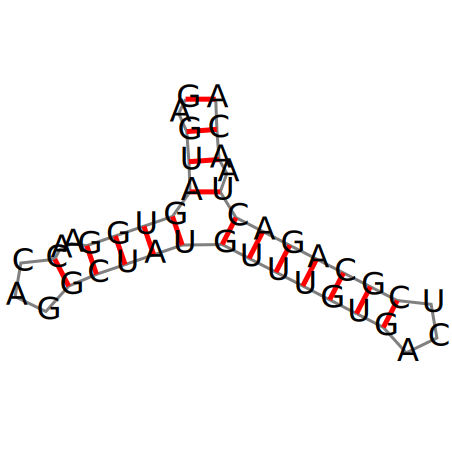

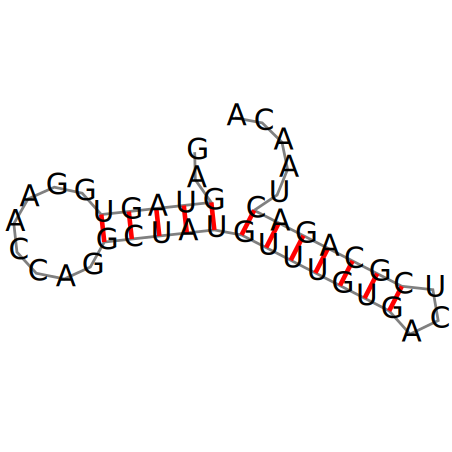

In [12]:
# test: on a single sequence
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"

db = predict_structure(sequence, unpaired_score_simple, paired_score_simple, min_loop=3)
mol = RnaMolecule(sequence, db)
mol.plot()

db2 = predict_structure_mfe(sequence)
mol2 = RnaMolecule(sequence, db2)
mol2.plot()

### Using MTA: Maximum total accuracy
Given an alignment and the list of corresponding structures, we try to find the consensus structure that maximises the agreement with all the given structures.

The agreement of two structures R and R' is mesured by their accuracy:
$$Acc(R,R')= 2λ|R ∩ R'| + |R^u ∩ R'^u |$$
R and R' beeing the set of pairs, and $R^u$ and $R'^u$ the set of unpaired positions.

In [40]:
def unpaired_accuracy_MTA(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    unpaired = 0
    for mol in alignment:
        if mol.dbstring[i] == '.':
            unpaired += 1
    return unpaired

def paired_accuracy_MTA(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure'''
    paired = 0
    for mol in alignment:
        if (i,j) in mol.pairs or (j,i) in mol.pairs:
            paired += 1
    return 2*l*paired

In [ ]:
# test: on an easy alignment
seq = ["GC-C-AAA-GGC", "GGGC-AUU-GCC", "AC-GGAAUCCGU"]
db = ["((-(-...-)))", "((.(-...-)))", "((-((...))))"]

alignment = []
for i in range(len(seq)):
    alignment.append(RnaMolecule(seq[i],db[i]))
    print(db[i])

print(12*'_')
mta = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA)
print(mta)

((-(-...-)))
((.(-...-)))
((-((...))))
____________
((.(.....)))


### Using MEA: Maximum expected accuracy
For this, we need the base pair probability given by the Vienna package with `fc.bpp()`.

In [13]:
def unpaired_accuracy_MEA(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    unpaired = 0
    for mol in alignment:
        unpaired += 1-sum(mol.bpp[i][j] + mol.bpp[j][i] for j in range(1,len(mol.bpp)))
    return unpaired

def paired_accuracy_MEA(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure'''
    paired = 0
    for mol in alignment:
        paired += mol.bpp[i+1][j+1]
    return 2*l*paired

### Using conservation score
We add a bonus to the structure if two pairs have covariated to stay complementary:
$$
\delta_{cov}(i,j) = 1/2 \sum_{A, A' \in alignment} \begin{cases}
  1(A_i \neq A'_i) + 1(A_j \neq A'_j)  & \text{ if $A_i, A_j$ and $A'_i, A'_j$ compl.} \\
  0 & \text{otherwise}
\end{cases}
$$

and a malus if the matched pairs are not complementary:
$$
\delta_{inc}(i,j) = 1/2 \sum_{A \in alignment} \begin{cases}
  0 & \text{ if $A_i, A_j$ compl.} \\
  -0.25 & \text{ if $A_i, A_j$ gaps} \\
  -1 & \text{otherwise}
\end{cases}
$$

This measure can be combined with the MTA or the MEA to get a consensus alignment.

In [ ]:
def delta_cov(alignment:List[RnaMolecule], i:int, j:int)->float:
    '''Compute the covariance bonus'''
    res = 0
    n = len(alignment)
    for a in range(n):
        if is_canonical_basepair(alignment[a].sequence[i], alignment[a].sequence[j]):
            for b in range(a+1, n):
                if is_canonical_basepair(alignment[b].sequence[i], alignment[b].sequence[j]):
                    if alignment[a].sequence[i] != alignment[b].sequence[i]:
                        res += 1
                    if alignment[a].sequence[j] != alignment[b].sequence[j]:
                        res += 1
    return res/2

def delta_inc(alignment:List[RnaMolecule], i:int, j:int)->float:
    '''Compute the incompaty malus'''
    res = 0
    for mol in alignment:
        if is_canonical_basepair(mol.sequence[i], mol.sequence[j]):
            res += 0
        elif mol.sequence[i] == '-' and mol.sequence[j] == '-':
            res += 0.25
        else:
            res += 1
    return -res/2

def unpaired_MEA_with_conservation(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    return unpaired_accuracy_MEA(alignment, i)

def paired_MEA_with_conservation(alignment:List[RnaMolecule], i:int, j:int, l=1)->float:
    '''Compute the paired accuracy of a structure
     weight_cov and weight_inc are between 0 and 1 and sum inferior to 1'''
    return paired_accuracy_MEA(alignment, i, j, l) + delta_cov(alignment, i, j) + delta_inc(alignment, i, j)

def predict_structure_MEA_cons(alignment:List[RnaMolecule], unpaired_score, paired_score, min_loop=1,l=1)->str:
    '''Predict the consensus structure of an alignment'''
    n = 0
    if type(alignment[0]) == str:
        n = len(alignment)
    elif type(alignment[0]) == RnaMolecule:
        n = len(alignment[0].sequence)
    
    M = compute_matrix(alignment, n, unpaired_score, paired_score, min_loop,l)
    pairs = traceback_matrix(alignment, n, paired_score, M, min_loop,l)
    return pairs2db(n, pairs)

In [ ]:
# test: on a real example
sequences = read_file('data/Testdata/tRNA_7.stk')
sequences = [str(record.seq) for record in sequences]

alignment = []
for seq in sequences:
    mol = RnaMolecule(seq)
    mol.set_structure()
    alignment.append(mol)

for mol in alignment:
    print(mol.dbstring)

print(len(alignment[0].sequence)*'_')

mta = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA, min_loop=1)
print(mta)

mea = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, min_loop=1)
print(mea)

mcs = predict_structure(alignment, unpaired_MEA_with_conservation, paired_MEA_with_conservation, min_loop=1)
print(mcs)

mfe = predict_structure_mfe(sequences) # mfe from ViennaRNA also works directly for alignments
print(mfe)


(((((((..(((.............)))((((((.......))))))((((...))))..(((((.......)))))))))))).
(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).
(((((((...(((....)))......((((((((.......))))...........))))(((((.......)))))))))))).
((((((((((....((((......))))..((((.(((.((((.............)))).)))..))))...))).))))))).
.(((((((((........)))))))))...((((((((((((((..................))))))).....)))))))....
.....(((((((((................))))))))).....................(((((.......)))))........
(((((((..((((...........)))).(((((.......))))).................(((...))).....))))))).
_____________________________________________________________________________________
(((((((.......................((((.......))))...............(((((.......)))))))))))).
(((((((.......................((((.......))))................(((.........))).))))))).
(((((((..(((.............)))..((((.......))))...............((((.........))))))))))).
(((((((..(((.............)))..((((.......)))).........

# Benchmark:
TODO:
read alignment with reference structure
compute structure for different algorithms

compare with reference. different possible measures:
- agreement, see MTA
- compare base pairs: TP, FP, FN, see slides
- other

In [14]:
# to standardize the consensus secondary structure string
def standardize_ss_cons(ss_cons):
    """
    Standardize the consensus secondary structure string to use common symbols.

    Parameters:
    - ss_cons (str): Consensus secondary structure string to be standardized.

    Returns:
    - str: Standardized consensus secondary structure string.
    """
    standardized_ss_cons = ''
    for symbol in ss_cons:
        if symbol in ('(', '[', '{', '<'):
            standardized_ss_cons += '('
        elif symbol in (')', ']', '}', '>'):
            standardized_ss_cons += ')'
        else:
            standardized_ss_cons += '.'
    return standardized_ss_cons

In [15]:
def compare_base_pairs (reference:str, result:str)->float:
    ''' variant of the comparison between a reference and a predicted sructure.
        Args : 
            reference : str, official reference structure
            result : str, structure resulting from one of the algorithms'''
    #initialization :
    base_pairs_ref = db2pairs(reference)
    base_pairs_result = db2pairs(result)
    intersection = base_pairs_ref.intersection(base_pairs_result)

    #TP, FP, FN calculation :
    TP = len(intersection)
    FP = len(base_pairs_result) - len(intersection)
    FN = len(base_pairs_ref) - len(intersection)

    #results :
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F_measure = TP/(TP+0.5*(FP+FN))

    return "recall   ", recall, "precision   ", precision, "F measure   ", F_measure

In [16]:
# Variant 1 : we do not penalize compatible false positive predictions 
def variant_1 (reference:str, result:str)->float:
    ''' variant of the comparison between a reference and a predicted sructure. We do not penalize compatible false positive predictions
        Args : 
            reference : str, official reference structure
            result : str, structure resulting from one of the algorithms'''

    #initialization :
    base_pairs_ref = db2pairs(reference)
    base_pairs_result = db2pairs(result)
    intersection = base_pairs_ref.intersection(base_pairs_result)
    other_predictions = base_pairs_result - intersection
    not_compatible = set()
    for pairs in other_predictions:
        for other in (base_pairs_ref-intersection) : #here, we add the non compatible pairs to the set not_compatible
            if (pairs[0] not in other and pairs[1]  in other) or (pairs[0] in other and pairs[1]  not in other):
                not_compatible.add(pairs)
    TP = len(intersection) + len(other_predictions) - len(not_compatible)
    FP = len(not_compatible)
    FN = len(base_pairs_ref) - len(intersection)

    #results :
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F_measure = TP/(TP+0.5*(FP+FN))

    return "recall   ", recall, "precision   ", precision, "F measure   ", F_measure

In [17]:
# Variant 2 : we consider that base pairs shifted from one position are still valid (=one common end) :

def variant_2 (reference:str, result:str)->float:
    ''' variant of the comparison between a reference and a predicted sructure.
        Args : 
            reference : str, official reference structure
            result : str, structure resulting from one of the algorithms'''

    #initialization :
    base_pairs_ref = db2pairs(reference)
    base_pairs_result = db2pairs(result)
    intersection = base_pairs_ref.intersection(base_pairs_result)
    other_predictions = base_pairs_result - intersection
    shifted = set()
    for pairs in base_pairs_result - intersection:
        for other in base_pairs_ref: #here, we add the shifted pairs from one position to shifted
            if (pairs[0] in other and pairs[1] not in other) or (pairs[1] in other and pairs[0] not in other):
                shifted.add(pairs)
    TP = len(intersection) + len(shifted)
    FP = len(other_predictions) - len(shifted)
    FN = len(base_pairs_ref) - len(intersection) - len(shifted)

    #results :
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F_measure = TP/(TP+0.5*(FP+FN))

    return "recall   ", recall, "precision   ", precision, "F measure   ", F_measure

In [18]:
# variant 2 bis
def variant_2_bis (reference:str, result:str)->float:
    ''' variant of the comparison between a reference and a predicted sructure. the shifts only from one position are accepted
        Args : 
            reference : str, official reference structure
            result : str, structure resulting from one of the algorithms'''

    #initialization :
    base_pairs_ref = db2pairs(reference)
    base_pairs_result = db2pairs(result)
    intersection = base_pairs_ref.intersection(base_pairs_result)
    other_predictions = base_pairs_result - intersection
    shifted = set()
    for pairs in other_predictions :
        for other in base_pairs_ref: #here, we add the shifted pairs from one position to shifted
            # only one base is shifted
            if pairs[0] in other:
                if pairs[1] - 1 in other or pairs[1] + 1 in other:
                    shifted.add(pairs)
            elif pairs[1] in other:
                if pairs[0] - 1 in other or pairs[0] + 1 in other:
                    shifted.add(pairs)
            #both bases are shifted
            elif pairs[0] - 1 or pairs[0]+1 in other:
               if pairs[1] - 1 in other or pairs[1] + 1 in other:
                  shifted.add(pairs)
    TP = len(intersection) + len(shifted)
    FP = len(other_predictions) - len(shifted)
    FN = len(base_pairs_ref) - len(intersection) - len(shifted)

    #results :
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F_measure = TP/(TP+0.5*(FP+FN))

    return "recall   ", recall, "precision   ", precision, "F measure   ", F_measure

In [19]:
ref = AlignIO.read("RF00100.stockholm.txt", "stockholm")

In [22]:
# Firsts tests :

ss_cons = ref.column_annotations['secondary_structure']

ss_cons = standardize_ss_cons(ss_cons)

j=50

references = [str(record.seq) for record in ref[0:j]]
alignment = []
for seq in references:
    mol = RnaMolecule(seq)
    mol.set_structure()
    alignment.append(mol)



In [ ]:
#test of MTA on the j first sequences of the alignment
pred_MTA = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA, min_loop=1)

# test of MEA on the j first sequences of the alignment
pred_MEA = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, min_loop=1)

# test of MEA with conservation on the j first sequences of the alignment
pred_MEA_with_conservation = predict_structure(alignment, unpaired_MEA_with_conservation, paired_MEA_with_conservation, min_loop=1)

In [ ]:
print(compare_base_pairs(ss_cons, pred_MTA))
print(variant_1(ss_cons, pred_MTA))
print(variant_2(ss_cons, pred_MTA))
print(variant_2_bis(ss_cons, pred_MTA))

('recall   ', 0.22988505747126436, 'precision   ', 0.37735849056603776, 'F measure   ', 0.2857142857142857)
('recall   ', 0.2717391304347826, 'precision   ', 0.4716981132075472, 'F measure   ', 0.3448275862068966)
('recall   ', 0.5517241379310345, 'precision   ', 0.9056603773584906, 'F measure   ', 0.6857142857142857)
('recall   ', 0.4827586206896552, 'precision   ', 0.7924528301886793, 'F measure   ', 0.6)


In [ ]:
print(compare_base_pairs(ss_cons, pred_MEA))
print(variant_1(ss_cons, pred_MEA))
print(variant_2(ss_cons, pred_MEA))
print(variant_2_bis(ss_cons, pred_MEA))

# All the algorithms have the same results.
#It is logical because MEA keeps the paired or unpaired condition with the higher probability.
# And yet, there is a low probability that a shift occurs in many sequences, and also a low probability that the same 
# compatible base pairs occurs in several sequences.

('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)
('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)
('recall   ', 0.06896551724137931, 'precision   ', 1.0, 'F measure   ', 0.12903225806451613)
('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)


Analyzis : Recall very low -> MEA non optimized forgets a lot of pairs but has no false positive. We have to give more weigh to the pairs thanks to lambda.
We keep the variant 2 bis for the evaluation because it is more relevant to evaluate MEA with conservation that allows covariations.
variant 1 also interesting BECAUSE ?

In [ ]:
#A DEPLACER APRÈS L'OPTIMISATION DE MEA 
print(compare_base_pairs(ss_cons, pred_MEA_with_conservation))
print(variant_1(ss_cons, pred_MEA_with_conservation))
print(variant_2(ss_cons, pred_MEA_with_conservation))
print(variant_2_bis(ss_cons, pred_MEA_with_conservation))


('recall   ', 0.2413793103448276, 'precision   ', 0.3559322033898305, 'F measure   ', 0.2876712328767123)
('recall   ', 0.32653061224489793, 'precision   ', 0.5423728813559322, 'F measure   ', 0.40764331210191085)
('recall   ', 0.5517241379310345, 'precision   ', 0.8135593220338984, 'F measure   ', 0.6575342465753424)
('recall   ', 0.5172413793103449, 'precision   ', 0.7627118644067796, 'F measure   ', 0.6164383561643836)


### Conclusion :
- on the different evaluations
TO FINISH

### Find the best parameters for MEA

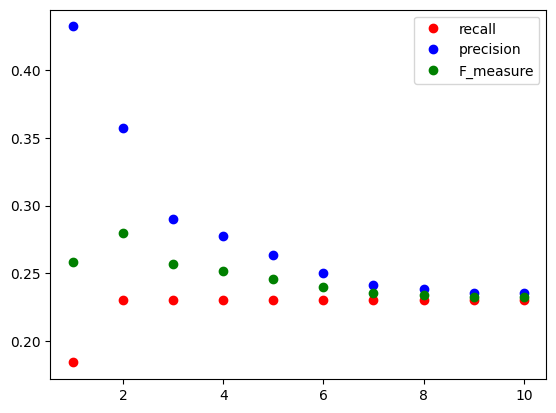

In [ ]:
def test_MEA (lambdas, alignment, ss_cons) :
    scores =[]
    for l in lambdas :
        pred_MEA = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, 1,l)
        scores.append(variant_1(ss_cons, pred_MEA))

    recall = []
    precision = []  
    F_measure = []
    for i in range (len(scores)) :
        recall.append(scores[i][1])
        precision.append(scores[i][3])
        F_measure.append(scores[i][5])

    plt.plot(lambdas, recall, 'or', label = "recall")
    plt.plot(lambdas, precision, 'ob', label = "precision") 
    plt.plot(lambdas, F_measure, 'og', label = "F_measure")
    plt.legend()
    plt.show()

#test of MEA with a certain number of values of lambda tested :
lambdas = [i for i in range(1, 11)]
test_MEA(lambdas, alignment, ss_cons)


Lambda = 2 seems to be the best option here :
- the recall value is not better after ;
- the precision is not yet down ;
- and consequently th F_measure is the best one ;

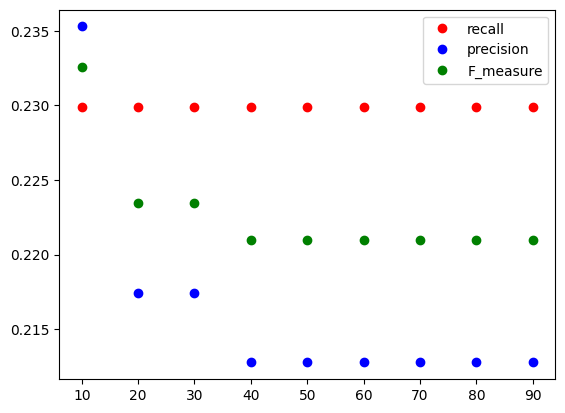

In [ ]:
# Just to check that there is no other good value for lambda, higher thant 10 :
lambdas2 = [ i for i in range (10,100,10)]
test_MEA(lambdas2, alignment, ss_cons)

The results will be better with lambda in [0,10].

For more precision, let's execute the algorithm on a very short interval centered on 2.

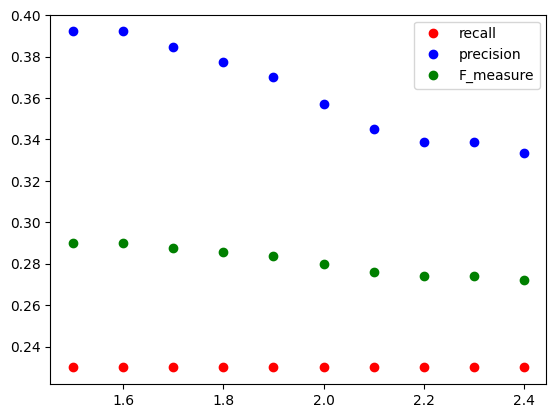

In [ ]:
lambdas3 = [1.5+i/10 for i in range(0,10)]
test_MEA(lambdas3, alignment, ss_cons)

Thus, the best lambda parameter for Maximum Expected Accuracy seems to be about 1.6 (recall score very constant, precision score much better under 1.7)
Is i

In [ ]:
# (A test was done withe the variant 2 bis evaluation and the results were equivalent)
#new test after optimization :
pred_MEA = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, min_loop=1,l=1.6)
print(compare_base_pairs(ss_cons, pred_MEA))
print(variant_1(ss_cons, pred_MEA))
print(variant_2(ss_cons, pred_MEA))
print(variant_2_bis(ss_cons, pred_MEA))

('recall   ', 0.22988505747126436, 'precision   ', 0.3508771929824561, 'F measure   ', 0.2777777777777778)
('recall   ', 0.27956989247311825, 'precision   ', 0.45614035087719296, 'F measure   ', 0.3466666666666667)
('recall   ', 0.5862068965517241, 'precision   ', 0.8947368421052632, 'F measure   ', 0.7083333333333334)
('recall   ', 0.5402298850574713, 'precision   ', 0.8245614035087719, 'F measure   ', 0.6527777777777778)


For comparison, here are the precedent results :


('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)


('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)


('recall   ', 0.06896551724137931, 'precision   ', 1.0, 'F measure   ', 0.12903225806451613)


('recall   ', 0.05747126436781609, 'precision   ', 0.8333333333333334, 'F measure   ', 0.10752688172043011)

--> We really enhance the recall (*5-10), and we keep a good precision.

### Find the best parameters for MEA with conservation

For the optimization of the MEA correction, we are forced to modify the precedent functions in order to add weight parameters easily.

In [20]:
def compute_matrix_2(alignment:List[RnaMolecule], n, unpaired_score, paired_score,l,weight_paired, weight_cov, weight_inc,min_loop=1)->np.array:
    '''Predict folding of RNA alignement using modified Nussinov algorithm'''

    M = np.zeros((n, n))

    # initialize the matrix
    for i in range(n):
        for j in range(i, min(n,i+min_loop+1)):
            M[i][j] = unpaired_score(alignment, i)
    # fill the matrix
    for i in reversed(range(n)):
        for j in range(i+min_loop+1, n):
            M[i][j] = max([M[i,k] + M[k+1,j] for k in range(i, j)])
            M[i][j] = max(M[i][j], M[i+1,j-1] + paired_score(alignment, i, j,l,weight_paired, weight_cov, weight_inc))
    return M

def traceback_matrix_2(alignment:List[RnaMolecule], n, paired_score, M:np.array,l,weight_paired, weight_cov, weight_inc,min_loop=1) -> list:
    '''Traceback the modified Nussinov matrix to find the pairs'''
     
    def traceback_position_2(i,j,l,weight_paired, weight_cov, weight_inc):
        pairs = []
        while j-i >= min_loop:
            if M[i][j] == M[i+1][j-1] + paired_score(alignment, i, j,l, weight_paired, weight_cov, weight_inc):
                pairs.append((i,j))
                i += 1
                j -= 1
            elif M[i][j] == M[i+1][j]:  # not necessary, but avoids some recurisve calls
                i += 1
            elif M[i][j] == M[i][j-1]:
                j -= 1
            else:
                for k in range(i, j):
                    if M[i][j] == M[i][k] + M[k+1][j]:
                        pairs += traceback_position_2(i, k,l, weight_paired, weight_cov, weight_inc)
                        pairs += traceback_position_2(k+1, j,l, weight_paired, weight_cov, weight_inc)
                        return pairs
        return pairs

    return traceback_position_2(0, n-1,l, weight_paired, weight_cov, weight_inc)

def predict_structure_2(alignment:List[RnaMolecule], unpaired_score, paired_score,l,weight_paired, weight_cov,weight_inc,min_loop=1)->str:
    '''Predict the consensus structure of an alignment'''
    n = 0
    if type(alignment[0]) == str:
        n = len(alignment)
    elif type(alignment[0]) == RnaMolecule:
        n = len(alignment[0].sequence)
    
    M = compute_matrix_2(alignment, n, unpaired_score, paired_score,l, weight_paired, weight_cov, weight_inc,min_loop)
    pairs = traceback_matrix_2(alignment, n, paired_score, M, l, weight_paired, weight_cov, weight_inc, min_loop)
    return pairs2db(n, pairs)

def delta_cov_2(alignment:List[RnaMolecule], i:int, j:int,weight_cov)->float:
    '''Compute the covariance bonus'''
    res = 0
    n = len(alignment)
    for a in range(n):
        if is_canonical_basepair(alignment[a].sequence[i], alignment[a].sequence[j]):
            for b in range(a+1, n):
                if is_canonical_basepair(alignment[b].sequence[i], alignment[b].sequence[j]):
                    if alignment[a].sequence[i] != alignment[b].sequence[i]:
                        res += 1
                    if alignment[a].sequence[j] != alignment[b].sequence[j]:
                        res += 1
    return res*weight_cov

def delta_inc_2(alignment:List[RnaMolecule], i:int, j:int,weight_inc)->float:
    '''Compute the incompaty malus'''
    res = 0
    for mol in alignment:
        if is_canonical_basepair(mol.sequence[i], mol.sequence[j]):
            res += 0
        elif mol.sequence[i] == '-' and mol.sequence[j] == '-':
            res += 0.25
        else:
            res += 1
    return -res*weight_inc

def unpaired_MEA_cons_2(alignment:List[RnaMolecule], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    return unpaired_accuracy_MEA(alignment, i)

def paired_MEA_cons_2(alignment:List[RnaMolecule], i:int, j:int, l,weight_paired, weight_cov,weight_inc)->float:
    '''Compute the paired accuracy of a structure
     weight_paired, weight_cov and weight_inc are between 0 and 1 and sum inferior to 1'''
    return weight_paired*paired_accuracy_MEA(alignment, i, j, l) + delta_cov_2(alignment, i, j, weight_cov) + delta_inc_2(alignment, i, j, weight_inc)

def predict_structure_MEA_cons_2(alignment:List[RnaMolecule], unpaired_score, paired_score, l, weight_paired, weight_cov, weight_inc, min_loop=1)->str:
    '''Predict the consensus structure of an alignment'''
    n = 0
    if type(alignment[0]) == str:
        n = len(alignment)
    elif type(alignment[0]) == RnaMolecule:
        n = len(alignment[0].sequence)
    
    M = compute_matrix_2(alignment, n, unpaired_score, paired_score,l, weight_paired, weight_cov, weight_inc, min_loop)    
    pairs = traceback_matrix_2(alignment, n, paired_score, M, l, weight_paired, weight_cov, weight_inc,min_loop=1)
    return pairs2db(n, pairs)

In [21]:
# First test to have a first idea of the results (the coefficients are chosen in order to follow the 1:0.5:0/5 ratio)
scores =[]
pred_MEA = predict_structure_MEA_cons_2(alignment, unpaired_MEA_cons_2, paired_MEA_cons_2, 1.6, 1/2, 0.25, 0.25)
print(compare_base_pairs(ss_cons, pred_MEA))
print(variant_1(ss_cons, pred_MEA))
print(variant_2(ss_cons, pred_MEA))
print(variant_2_bis(ss_cons, pred_MEA))
print(scores)

NameError: name 'ss_cons' is not defined

From the results we can deduce :
- recall < precision --> there is more False Negative than False positive so we have to boost the pairs thanks to the covariation score.
- the variant_1 evaluation is the worst one after the basic evaluation -> there is less Compatible False Positive than shifts from one position.

First : a very simple first optimization of the parameters. We could expect that a higher weight cov gives better results.

6
6
6
6
6
6
6
6
6
6


TypeError: plot() got an unexpected keyword argument 'x'

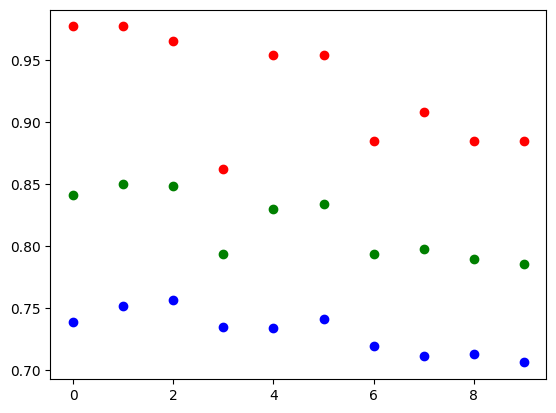

In [31]:
scores =[]
length = 0
for wcov in range (1,5) :
    for winc in range (1,6-wcov) :
        wpaired = 6-wcov-winc
        print(wcov+winc+wpaired)
        pred_MEA = predict_structure_MEA_cons_2(alignment, unpaired_MEA_cons_2, paired_MEA_cons_2, 1.6, wpaired, wcov, winc)
        scores.append(variant_2(ss_cons, pred_MEA))
        length += 1

X = [i for i in range(length)]
recall = []
precision = []  
F_measure = []
for i in range (len(scores)) :
    recall.append(scores[i][1])
    precision.append(scores[i][3])
    F_measure.append(scores[i][5])

plt.plot(X, recall, 'or', label = "recall")
plt.plot(X, precision, 'ob', label = "precision") 
plt.plot(X, F_measure, 'og', label = "F_measure")
plt.legend()
plt.show()

Results :
- best scores for the three first values so wcov = 1
- best recall for wcov = 1, winc = 2, wpaired = 3
- best precision for wcov = 1, winc = 3, wpaired = 2

Let's take wcov = 1, winc = 2, wpaired = 3 since the F_measure is a little bit better

Next : the same but on smaller intervals centered on the best result.

In [48]:
#comparison with the function of the Vienna RNA package :
#print([str(record.seq) for record in ref[0:5]])
references = [str(record.seq) for record in ref[0:50]]
vienna = predict_structure_mfe(references)
print(variant_2(ss_cons, pred_MEA))

('recall   ', 0.8850574712643678, 'precision   ', 0.7064220183486238, 'F measure   ', 0.7857142857142857)


### Time comparison between the different algorithms

reprendre mta, mfe, mea avec ou sans poids.
choisir une liste de séquences.
fixer lambda (et les poids)

rélaiser une courbe en fonction du temps pour chaque algorithme en fonction de la taille de l'alignement/du nombre de séquences 
(séquences plus pertinent sans doute puisque nos alignements sont tous assez courts.)

pas besoin de la comparaison au modèle a priori, on a déjà déterminé le meilleur (?) JE DEVRAIS PEUT-ÊTRE OPTIMISER LES PARAMÈTRE 
POUR MFE ET MTA ÉGALEMENT.

In [36]:
#ss_cons = ref.column_annotations['secondary_structure']
#ss_cons = standardize_ss_cons(ss_cons)
import time

#parametization :
wpaired = 3
wcov = 1
winc = 2

In [38]:
def impact_number_of_sequences (j, extracted_data) :
    references = [str(record.seq) for record in extracted_data[0:j]]
    alignment = []
    for seq in references:
        mol = RnaMolecule(seq)
        mol.set_structure()
        alignment.append(mol)

    #test of MTA on the j first sequences of the alignment
    begin = time.time()
    pred_MTA = predict_structure(alignment, unpaired_accuracy_MTA, paired_accuracy_MTA, min_loop=1)
    end = time.time()
    time_MTA = end - begin

    # test of MEA on the j first sequences of the alignment
    begin = time.time()
    pred_MEA = predict_structure(alignment, unpaired_accuracy_MEA, paired_accuracy_MEA, 1, 1.6)
    end = time.time()
    time_MEA = end - begin

    # test of MEA with conservation on the j first sequences of the alignment
    begin = time.time()
    pred_MEA_cons = predict_structure_MEA_cons_2(alignment, unpaired_MEA_cons_2, paired_MEA_cons_2, 1.6, wpaired, wcov, winc)
    end = time.time()
    time_MEA_cons = end - begin

    return 'MTA : ',time_MTA,' MEA : ', time_MEA,' MEA with conservation : ', time_MEA_cons

In [42]:
#sans doute pas très intéressant.
#test 1 : 1 total sequence
test_1 = impact_number_of_sequences(1, ref)
print('test 1 : ', test_1)

#test 2 : 10 total sequences,  long
test_2 = impact_number_of_sequences(10, ref)
print('test 2 : ', test_2)

#test 3 : 50 total sequences, short ?
test_3 = impact_number_of_sequences(50, ref)
print('test 3 : ', test_3)

test 1 :  ('MTA : ', 6.519132852554321, ' MEA : ', 5.923492670059204, ' MEA with conservation : ', 6.233362197875977)


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (49,) and (10,)

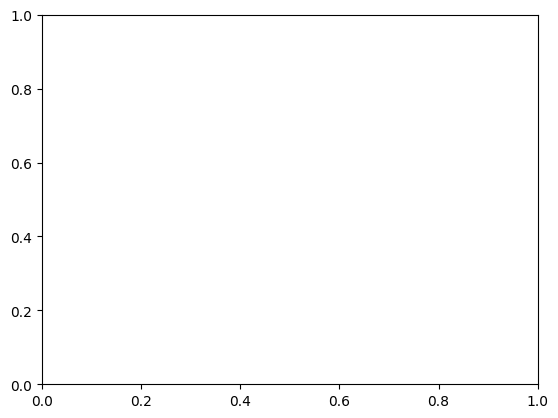

In [44]:
# Evolution of the time of execution of the algorithms with the number of sequences in the alignment (from 1 to ten)
X = [i for i in range(1,50)]
Y_MTA = []
Y_MEA = []
Y_MEA_cons = []
for j in range(1,11) :
    test = impact_number_of_sequences(j, ref)
    Y_MTA.append(test[1])
    Y_MEA.append(test[3])
    Y_MEA_cons.append(test[5])  

plt.plot(X, Y_MTA, 'or', label = "MTA")
plt.plot(X, Y_MEA, 'ob', label = "MEA")
plt.plot(X, Y_MEA_cons, 'og', label = "MEA with conservation")
plt.legend()
plt.show()